# Optimizing EKG Circuit

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
ohm = UNITS.ohm
farad = UNITS.farad
volt = UNITS.volt
Hz = UNITS.Hz
second = UNITS.second;

In [3]:
input_freq = Params(
    f = 50
)

,values
f,50


In [4]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = input_freq.f,   # Hz
    vin = 0
)

,values
R,4900.000000
C,0.000001
A,5.000000
f,50.000000
vin,0.000000


In [5]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    omega = 2 * np.pi * input_freq.f
    tau = R * C
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / input_freq.f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=input_freq.f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [6]:
system1 = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.0049
cutoff,32.4806


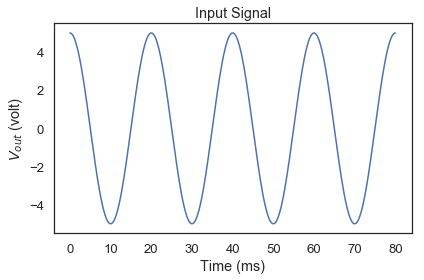

In [7]:
x = linspace(0, system1.t_end * 1000, 401)
v = A * np.cos(2 * pi * (f / 1000) * x)
plt.plot(x, v)
decorate(xlabel='Time (ms)',
             ylabel='$V_{out}$ (volt)',
             title='Input Signal',
             legend=False)

In [8]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)"""

    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [9]:
results1, details1 = run_ode_solver(system1, slope_func_init, t_eval=system1.ts)

In [10]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

In [11]:
params2 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,100000
C,1e-06
vin,0.0000 0.000000 0.0002 0.199840 0.0004 ...


In [12]:
system2 = make_system(params2)

,values
R,100000
C,1e-06
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.1
cutoff,1.59155


In [13]:
def slope_func_high_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    unpack(system)
    
    vin1 = A * np.cos(2 * pi * f * t)
    
    #vin = interpolate(system.vin)
    
    dvindt = (vin1 - vout) / (R * C)
    
    dvoutdt = dvindt - ((vout) / (R * C))
    
    return dvoutdt

In [14]:
def slope_func_low_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

In [15]:
results2, details2 = run_ode_solver(system2, slope_func_high_pass, t_eval=system2.ts)

In [16]:
params3 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results2.V_out
)

,values
R,499
C,1e-05
vin,0.0000 0.000000 0.0002 0.009973 0.0004 ...


In [17]:
system3 = make_system(params3)

,values
R,499
C,1e-05
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.00499
cutoff,31.8948


In [18]:
results3, details3 = run_ode_solver(system3, slope_func_low_pass, t_eval=system3.ts)

In [19]:
params4 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results3.V_out
)

,values
R,4900
C,1e-06
vin,0.0000 0.000000 0.0002 0.000197 0.0004 ...


In [20]:
system4 = make_system(params4)

,values
R,4900
C,1e-06
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.0049
cutoff,32.4806


In [21]:
results4, details4 = run_ode_solver(system4, slope_func_low_pass, t_eval=system4.ts)

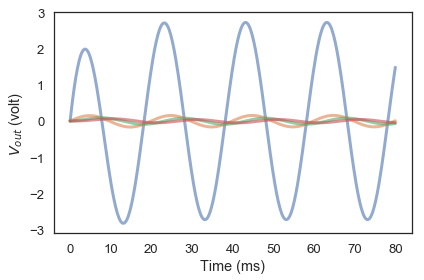

In [22]:
plot_results(results1)
plot_results(results2)
plot_results(results3)
plot_results(results4)

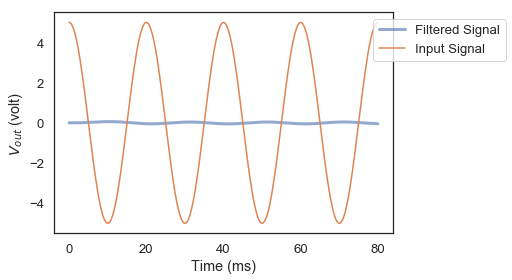

In [23]:
#plt.xkcd()
plot_results(results4)
plt.plot(x, v)
plt.legend(["Filtered Signal", "Input Signal"], loc='upper right', bbox_to_anchor=(1.35, 1))

In [24]:
params_total = Params(
    R1 = 4.9e3,   # ohm
    C1 = 1e-6,  # farad
    
    vin2 = results1.V_out,
    R2 = 100e3,   # ohm
    C2 = 1e-6,  # farad
    
    vin3 = results2.V_out,
    R3 = 499,   # ohm
    C3 = 10e-6,  # farad
    
    vin4 = results3.V_out,
    R4 = 4.9e3,   # ohm
    C4 = 1e-6  # farad
)

,values
R1,4900
C1,1e-06
vin2,0.0000 0.000000 0.0002 0.199840 0.0004 ...
R2,100000
C2,1e-06
vin3,0.0000 0.000000 0.0002 0.009973 0.0004 ...
R3,499
C3,1e-05
vin4,0.0000 0.000000 0.0002 0.000197 0.0004 ...
R4,4900


In [25]:
def amp(R):
    G = 1 + (100e3/R)
    return G

In [26]:
G1 = amp(2e3)
G2 = amp(4.9e3);

In [27]:
def run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass, G1, G2):
    
    params5 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5 * G1,      # volt
    f = input_freq.f,   # Hz
    vin = 0
    )
    
    system5 = make_system(params5)
    results5, details5 = run_ode_solver(system5, slope_func_init, t_eval=system5.ts)
    
    params6 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results5.V_out
    )
    
    system6 = make_system(params6)
    results6, details6 = run_ode_solver(system6, slope_func_high_pass, t_eval=system6.ts)
    
    params7 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results6.V_out * G2
    )
    
    system7 = make_system(params7)
    results7, details7 = run_ode_solver(system7, slope_func_low_pass, t_eval=system7.ts)
    
    params8 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results7.V_out
    )
    
    system8 = make_system(params8)
    results8, details8 = run_ode_solver(system8, slope_func_low_pass, t_eval=system8.ts)
    
    A_in = params5.A
    
    A_out=(results8.V_out.max()-results8.V_out.min())/2
        
    ratio = A_out/A_in
    
    return State(results5=results5, results6=results6, result7=results7, results8=results8, ratio=ratio)

In [28]:
input_freq.f = 50

In [29]:
results5, results6, results7, results8, ratio = run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass, G1, G2)

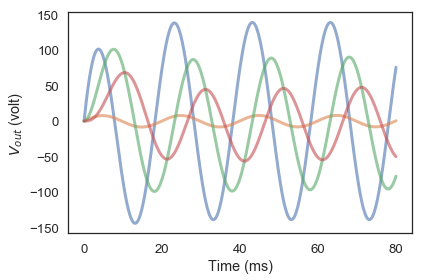

In [30]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [33]:
sweep = SweepSeries()
for f in linspace(1, 100, 50):
    input_freq.f=f
    state = run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass, G1, G2).ratio
    sweep[f] = state;

1      10.197651
3       7.765590
5       5.721766
7       4.360892
9       3.436437
11      2.777009
13      2.286031
15      1.910413
17      1.614331
19      1.375114
21      1.180210
23      1.019132
25      0.883861
27      0.770262
29      0.683819
31      0.609985
33      0.546003
35      0.490474
37      0.441881
39      0.399260
41      0.361922
43      0.328699
45      0.301777
47      0.276901
49      0.254763
51      0.235084
53      0.217114
55      0.201070
57      0.186681
59      0.173584
61      0.161632
63      0.152690
65      0.140752
67      0.131721
69      0.123395
71      0.115944
73      0.108831
75      0.102378
77      0.096689
79      0.091285
81      0.086353
83      0.081716
85      0.077447
87      0.073453
89      0.069748
91      0.066270
93      0.063024
95      0.059960
97      0.057083
100     0.053145
dtype: float64


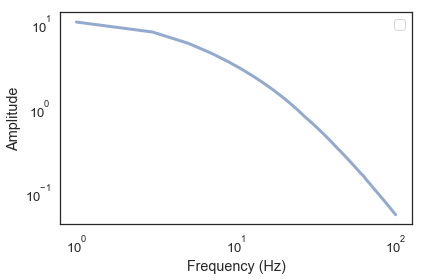

In [34]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log')

print(sweep)

In [40]:
from pandas import read_csv
data = read_csv("Lab_5_Bode.csv")
data.columns = ["Frequency", "nah", "Amplitude", "no"]
print(data)

      Frequency        nah  Amplitude          no
0      0.578918  -2.749676   9.166125 -176.776346
1      0.670291  -1.731548   8.851733 -178.787299
2      0.776087  -0.761154   8.535242  178.534970
3      0.898581   0.156845   8.211789  175.038234
4      1.040408   1.015491   7.870623  170.544264
5      1.204622   1.811066   7.494035  164.908806
6      1.394753   2.538186   7.050318  157.974252
7      1.614894   3.200437   6.611048  150.992660
8      1.869782   3.794163   6.177780  145.023498
9      2.164899   4.320080   5.702062  140.312912
10     2.506597   4.780999   5.206926  138.970816
11     2.902226   5.179527   4.752079  139.710698
12     3.360299   5.518815   4.332876  140.403938
13     3.890673   5.802273   3.944903  140.576621
14     4.504759   6.033817   3.576641  140.199282
15     5.215768   6.219584   3.213725  139.137557
16     6.039000   6.358525   2.846817  137.328208
17     6.992167   6.447138   2.465623  134.754803
18     8.095778   6.488456   2.053791  131.427648


In [52]:
def plot_data(data):
    f = (data.Frequency)
    a = (data.Amplitude)
       
    plot(f, a)
    decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log',
             title='Bode Plot Collected Data',
             legend=False)

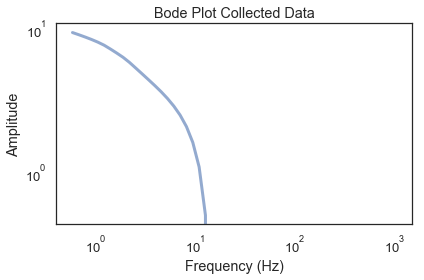

In [53]:
plot_data(data)

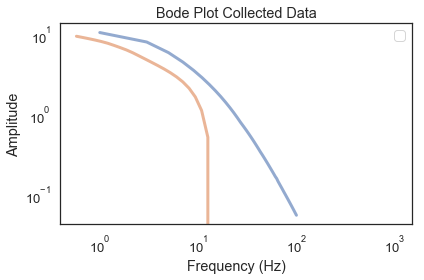

In [54]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             title='Bode Plot Simulated VS Collected Data')
plot_data(data)